In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import optuna

def transform_features(df):
    """
    Apply transformations to the input DataFrame based on observed distributions.
    """
    # Log transformation for MW
    if 'MW' in df.columns:
        df['MW_log'] = np.log1p(df['MW'])  # log(1+x) to avoid log(0)
        df.drop(columns=['MW'], inplace=True)
    
    if "NumOfConfUsed" in df.columns:
        df['NumOfConfUsed_log'] = np.log1p(df['NumOfConfUsed'])
        df['NumOfConfUsed_binned'] = pd.cut(df['NumOfConfUsed'], bins=[0, 10, 20, 30, 40], labels=[1, 2, 3, 4])
        df.drop(columns=['NumOfConfUsed'], inplace=True)
    
    if 'NumOfAtoms' in df.columns:
        df['NumOfAtoms_sqrt'] = np.sqrt(df['NumOfAtoms'])
        df['ConfUsed_to_Atoms'] = df['NumOfConfUsed_log'] / (df['NumOfAtoms'] + 1e-5)  # Avoid division by zero
        df.drop(columns=['NumOfAtoms'], inplace=True)
    
    #Bin NumOfN into categories
    #if 'NumOfN' in df.columns:
    #    bins = [-1, 0, 1, 2]  # Define bin edges
    #    labels = ['0', '1', '2']
    #    df['NumOfN_binned'] = pd.cut(df['NumOfN'], bins=bins, labels=labels, include_lowest=True)
    #    df.drop(columns=['NumOfN'], inplace=True)
    
    if 'NumOfN_binned' in df.columns:
        df['NumOfN_binned'] = df['NumOfN_binned'].astype(int)  # Convert categories to integers

    if 'NumOfConfUsed_binned' in df.columns:
        df['NumOfConfUsed_binned'] = df['NumOfConfUsed_binned'].astype(int)  # Convert categories to integers
        
    df['Conf_to_ConfUsed_ratio'] = df['NumOfConf'] / df['NumOfConfUsed_binned']
    df['MW_to_NumOfAtoms'] = df['MW_log'] / df['NumOfAtoms_sqrt']
    df['Experimental11'] = df['NumHBondDonors'] / df['NumOfConf'] # addition to best2
    df['Experimental2'] = df['NumOfN'] / df['NumOfAtoms_sqrt']
    df['Experimental3'] = df['NumOfO'] / df['NumOfAtoms_sqrt']
    df['Experimental4'] = df['NumOfC'] / df['NumOfAtoms_sqrt']
    df['Inter1'] = df['NumHBondDonors'] * df['MW_log']# addition to best2


    return df

def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 150),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'cat_smooth': trial.suggest_float('cat_smooth', 1.0, 50.0),
        'random_state': 4,
        'n_jobs': -1
    }
    
    model = lgb.LGBMRegressor(**param, verbose=-1)
    
    kf = KFold(n_splits=10, shuffle=True, random_state=4)
    scores = cross_val_score(model, train_transformed, target, cv=kf, scoring='neg_mean_absolute_error')
    return -scores.mean()

# Load data
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")

# Preserve the ID column
test_ids = test["ID"]

# Drop ID column from test data
test.drop(columns=["ID"], inplace=True)

# Separate target variable from training data
target = train["log_pSat_Pa"]
train.drop(columns=["log_pSat_Pa", "ID"], inplace=True)

# Apply feature engineering
train_transformed = transform_features(train.copy())
test_transformed = transform_features(test.copy())

# One-hot encode categorical features "parentspecies" column
train_transformed = pd.get_dummies(train_transformed, columns=["parentspecies"], drop_first=True)
test_transformed = pd.get_dummies(test_transformed, columns=["parentspecies"], drop_first=True)

# Align the columns of train and test data
train_transformed, test_transformed = train_transformed.align(test_transformed, join='left', axis=1, fill_value=0)

# Separate the parentspecies columns
parentspecies_train = train_transformed.filter(like='parentspecies')
parentspecies_test = test_transformed.filter(like='parentspecies')

# Drop the parentspecies columns from the transformed data
train_transformed = train_transformed.drop(columns=parentspecies_train.columns)
test_transformed = test_transformed.drop(columns=parentspecies_test.columns)

# Save the column names before scaling
train_columns = train_transformed.columns
test_columns = test_transformed.columns

# Scale numerical features
scaler = StandardScaler()
train_transformed = scaler.fit_transform(train_transformed)
test_transformed = scaler.transform(test_transformed)

# Convert scaled numerical features back to DataFrame
train_transformed = pd.DataFrame(train_transformed, columns=train_columns)
test_transformed = pd.DataFrame(test_transformed, columns=test_columns)

# Add the parentspecies columns back to the scaled numerical features
train_transformed = pd.concat([train_transformed, parentspecies_train.reset_index(drop=True)], axis=1)
test_transformed = pd.concat([test_transformed, parentspecies_test.reset_index(drop=True)], axis=1)


# Hyperparameter tuning with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params
model = lgb.LGBMRegressor(**best_params)
model.fit(train_transformed, target)

# Predict on the training set
train_predictions = model.predict(train_transformed)

# Evaluate the model
rmse = mean_squared_error(target, train_predictions, squared=False)
mae = mean_absolute_error(target, train_predictions)
r2 = r2_score(target, train_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Predict on the test set
test_predictions = model.predict(test_transformed)

# Save predictions to a CSV file
output = pd.DataFrame({"ID": test_ids, "TARGET": test_predictions})
output.to_csv("optuna_lgbm_predictions888scaled.csv", index=False)

# view the feature importance
importance = model.feature_importances_
feature_names = train_transformed.columns
feature_importance = pd.DataFrame({"feature": feature_names, "importance": importance})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)
print(feature_importance)

# plot the feature importance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Feature Importance")
plt.show()


[I 2024-12-05 17:02:35,276] A new study created in memory with name: no-name-233c195b-76c5-47ba-ad91-42274b205e52
[I 2024-12-05 17:03:49,304] Trial 0 finished with value: 1.3210981605700631 and parameters: {'n_estimators': 1041, 'learning_rate': 0.32999166369035665, 'num_leaves': 132, 'max_depth': 14, 'min_child_samples': 45, 'subsample': 0.5182783007896448, 'colsample_bytree': 0.80691944636805, 'reg_alpha': 0.12801810945631487, 'reg_lambda': 0.39185354029564545, 'cat_smooth': 25.581973116570353}. Best is trial 0 with value: 1.3210981605700631.
[I 2024-12-05 17:03:54,014] Trial 1 finished with value: 1.2129074017182737 and parameters: {'n_estimators': 827, 'learning_rate': 0.11831338807018683, 'num_leaves': 90, 'max_depth': 1, 'min_child_samples': 77, 'subsample': 0.5788466764809213, 'colsample_bytree': 0.847130615486188, 'reg_alpha': 0.8145901540792431, 'reg_lambda': 0.8166362269401656, 'cat_smooth': 20.183532520354415}. Best is trial 1 with value: 1.2129074017182737.
[I 2024-12-05 17

KeyboardInterrupt: 

In [15]:
def transform_features2(df):
    """
    Apply transformations to the input DataFrame based on observed distributions.
    """
    # Log transformation for MW
    if 'MW' in df.columns:
        df['MW_log'] = np.log1p(df['MW'])  # log(1+x) to avoid log(0)
        df.drop(columns=['MW'], inplace=True)
    
    if "NumOfConfUsed" in df.columns:
        df['NumOfConfUsed_log'] = np.log1p(df['NumOfConfUsed'])
        df['NumOfConfUsed_binned'] = pd.cut(df['NumOfConfUsed'], bins=[0, 10, 20, 30, 40], labels=[1, 2, 3, 4])
        df.drop(columns=['NumOfConfUsed'], inplace=True)
    
    if 'NumOfAtoms' in df.columns:
        df['NumOfAtoms_sqrt'] = np.sqrt(df['NumOfAtoms'])
        df['ConfUsed_to_Atoms'] = df['NumOfConfUsed_log'] / (df['NumOfAtoms'] + 1e-5)  # Avoid division by zero
        df.drop(columns=['NumOfAtoms'], inplace=True)
    
    #Bin NumOfN into categories
    #if 'NumOfN' in df.columns:
    #    bins = [-1, 0, 1, 2]  # Define bin edges
    #    labels = ['0', '1', '2']
    #    df['NumOfN_binned'] = pd.cut(df['NumOfN'], bins=bins, labels=labels, include_lowest=True)
    #    df.drop(columns=['NumOfN'], inplace=True)
    
    if 'NumOfN_binned' in df.columns:
        df['NumOfN_binned'] = df['NumOfN_binned'].astype(int)  # Convert categories to integers

    if 'NumOfConfUsed_binned' in df.columns:
        df['NumOfConfUsed_binned'] = df['NumOfConfUsed_binned'].astype(int)  # Convert categories to integers
        
    df['Conf_to_ConfUsed_ratio'] = df['NumOfConf'] / df['NumOfConfUsed_binned']
    df['MW_to_NumOfAtoms'] = df['MW_log'] / df['NumOfAtoms_sqrt']
    df['Experimental11'] = df['NumHBondDonors'] / df['NumOfConf'] # addition to best2
    #df['Inter1'] = df['NumHBondDonors'] * df['MW_log']
    return df


def objective2(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 150),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'cat_smooth': trial.suggest_float('cat_smooth', 1.0, 50.0),
        'random_state': 4,
        'n_jobs': -1
    }
    
    model = lgb.LGBMRegressor(**param, verbose=-1)
    
    kf = KFold(n_splits=10, shuffle=True, random_state=4)
    scores = cross_val_score(model, train_transformed, target, cv=kf, scoring='neg_mean_absolute_error')
    return -scores.mean()


RMSE: 1.3407
MAE: 0.9889
R^2: 0.8154
                              feature  importance
28                     Experimental11        3409
25                  ConfUsed_to_Atoms        3136
27                   MW_to_NumOfAtoms        2639
26             Conf_to_ConfUsed_ratio        2604
4                           NumOfConf        2569
21                             MW_log        2199
22                  NumOfConfUsed_log        1645
0                              NumOfC        1513
9                              ketone        1240
7                    hydroxyl (alkyl)        1194
1                              NumOfO         943
8                            aldehyde         908
3                      NumHBondDonors         785
10                    carboxylic acid         739
17                           peroxide         696
19                 carbonylperoxyacid         630
16              carbonylperoxynitrate         608
18                      hydroperoxide         603
24           

/home/saavajuu/anaconda3/envs/iml_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'Feature Importance')

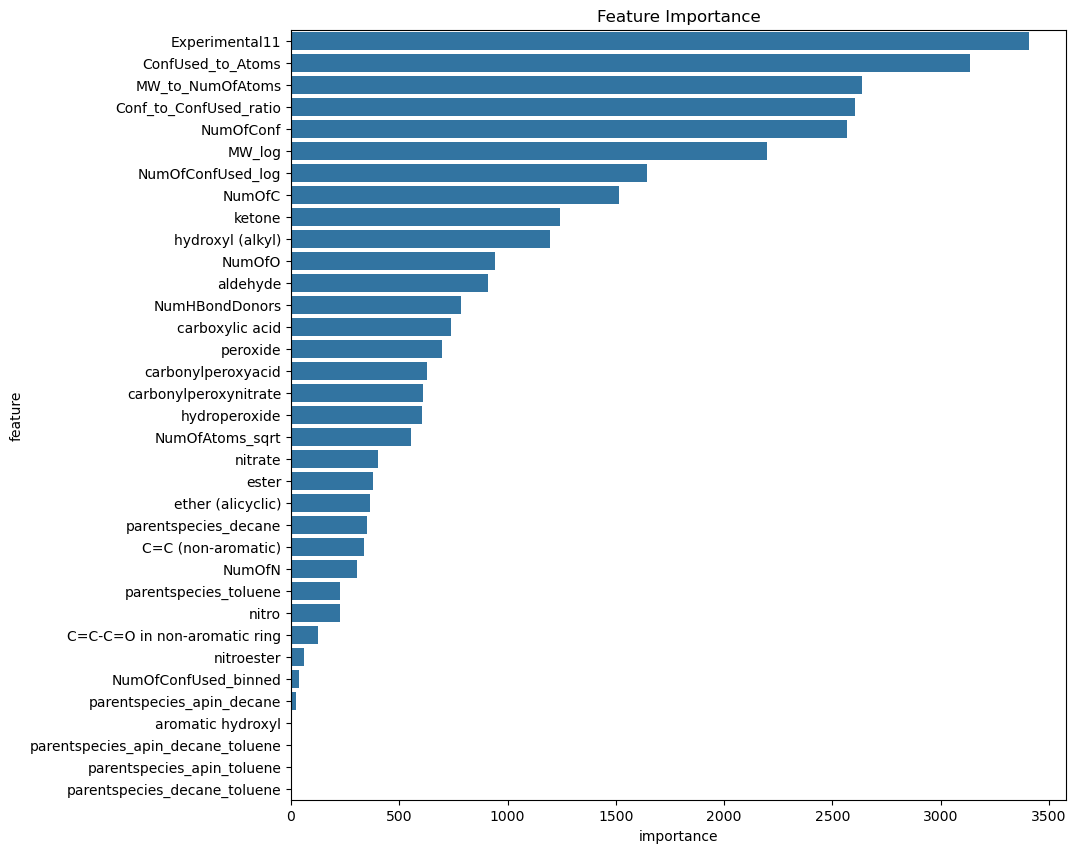

In [ ]:
# Load data
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")

# Preserve the ID column
test_ids = test["ID"]

# Drop ID column from test data
test.drop(columns=["ID"], inplace=True)

# Separate target variable from training data
target = train["log_pSat_Pa"]
train.drop(columns=["log_pSat_Pa", "ID"], inplace=True)

# Apply feature engineering
train_transformed = transform_features2(train.copy())
test_transformed = transform_features2(test.copy())

# One-hot encode categorical features "parentspecies" column
train_transformed = pd.get_dummies(train_transformed, columns=["parentspecies"], drop_first=True)
test_transformed = pd.get_dummies(test_transformed, columns=["parentspecies"], drop_first=True)

# Align the columns of train and test data
train_transformed, test_transformed = train_transformed.align(test_transformed, join='left', axis=1, fill_value=0)

# Separate the parentspecies columns
parentspecies_train = train_transformed.filter(like='parentspecies')
parentspecies_test = test_transformed.filter(like='parentspecies')

# Drop the parentspecies columns from the transformed data
train_transformed = train_transformed.drop(columns=parentspecies_train.columns)
test_transformed = test_transformed.drop(columns=parentspecies_test.columns)

# Save the column names before scaling
train_columns = train_transformed.columns
test_columns = test_transformed.columns

# Scale numerical features
scaler = StandardScaler()
train_transformed = scaler.fit_transform(train_transformed)
test_transformed = scaler.transform(test_transformed)

# Convert scaled numerical features back to DataFrame
train_transformed = pd.DataFrame(train_transformed, columns=train_columns)
test_transformed = pd.DataFrame(test_transformed, columns=test_columns)

# Add the parentspecies columns back to the scaled numerical features
train_transformed = pd.concat([train_transformed, parentspecies_train.reset_index(drop=True)], axis=1)
test_transformed = pd.concat([test_transformed, parentspecies_test.reset_index(drop=True)], axis=1)

# Hyperparameter tuning with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective2, n_trials=100)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
best_params = study.best_params

#best_params = {'n_estimators': 612, 'learning_rate': 0.03253420017567533, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 46, 'subsample': 0.7456333280664998, 'colsample_bytree': 0.9137393037318097, 'reg_alpha': 0.7026860907781649, 'reg_lambda': 0.7187304208680759}

model = lgb.LGBMRegressor(**best_params)
model.fit(train_transformed, target)

# Predict on the training set
train_predictions = model.predict(train_transformed)

# Evaluate the model
rmse = mean_squared_error(target, train_predictions, squared=False)
mae = mean_absolute_error(target, train_predictions)
r2 = r2_score(target, train_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Predict on the test set
test_predictions = model.predict(test_transformed)

# Save predictions to a CSV file
output = pd.DataFrame({"ID": test_ids, "TARGET": test_predictions})
output.to_csv("lgbm_best_reopt.csv", index=False)

# view the feature importance
importance = model.feature_importances_
feature_names = train_transformed.columns
feature_importance = pd.DataFrame({"feature": feature_names, "importance": importance})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)
print(feature_importance)

# plot the feature importance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Feature Importance")

### current best kaggle 0.7551 hps
Best hyperparameters:  {'n_estimators': 612, 'learning_rate': 0.03253420017567533, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 46, 'subsample': 0.7456333280664998, 'colsample_bytree': 0.9137393037318097, 'reg_alpha': 0.7026860907781649, 'reg_lambda': 0.7187304208680759}



run 7 feat plot
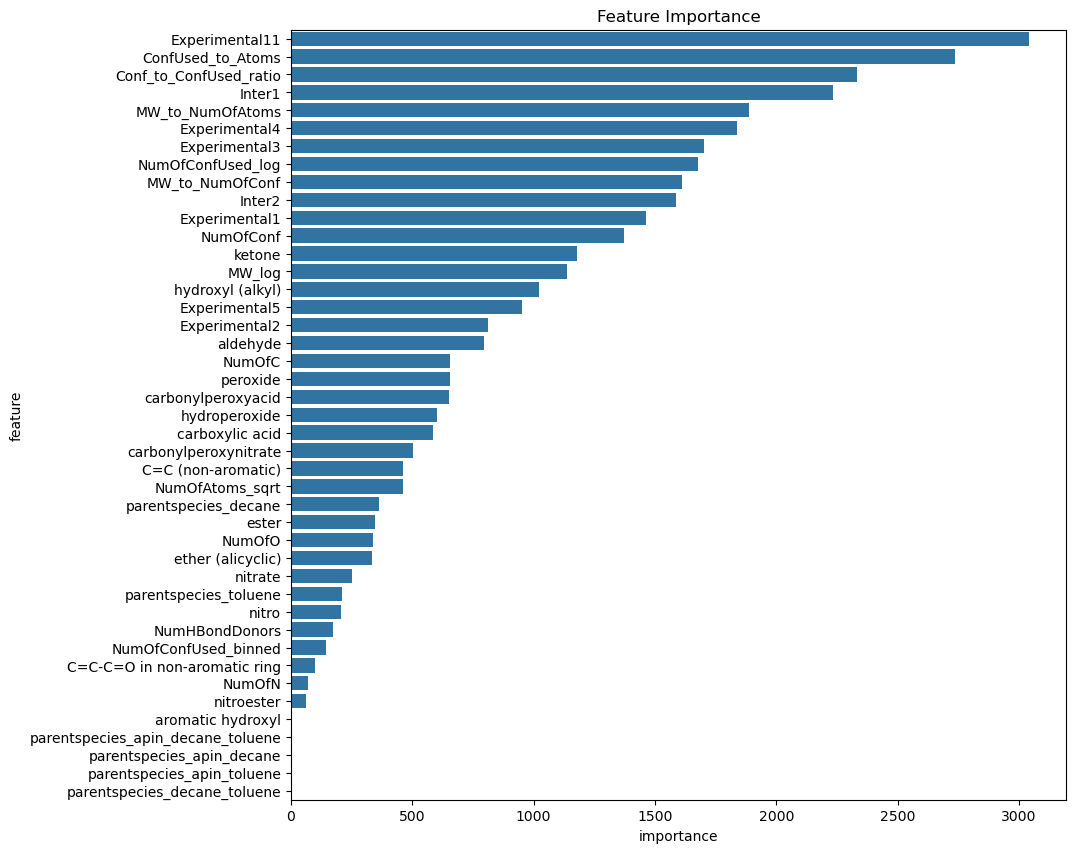

                              feature  importance
24                  ConfUsed_to_Atoms        8952
26             Conf_to_ConfUsed_ratio        7387
27                   MW_to_NumOfAtoms        6656
3                           NumOfConf        6455
28                    MW_to_NumOfConf        5949
20                             MW_log        5415
21                  NumOfConfUsed_log        4849
0                              NumOfC        2769
1                              NumOfO        2597
6                    hydroxyl (alkyl)        2546
8                              ketone        2353
2                      NumHBondDonors        2197
23                    NumOfAtoms_sqrt        2083
7                            aldehyde        1761
17                      hydroperoxide        1521
18                 carbonylperoxyacid        1513
9                     carboxylic acid        1374
16                           peroxide        1078
15              carbonylperoxynitrate        1059


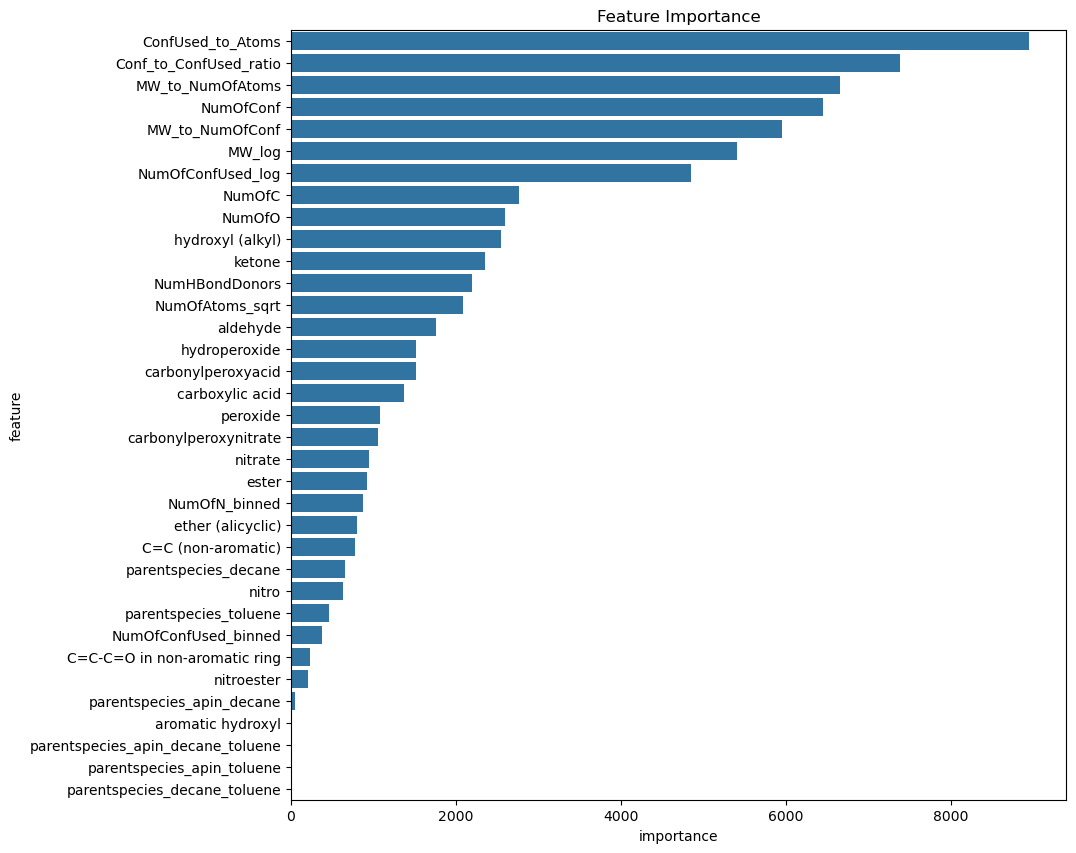

In [ ]:
# placeholder for viewwing the feature importance

In [5]:

best_params = study.best_params
model = lgb.LGBMRegressor(**best_params)
model.fit(train_transformed, target)

# Predict on the training set
train_predictions = model.predict(train_transformed)

# Evaluate the model
rmse = mean_squared_error(target, train_predictions, squared=False)
mae = mean_absolute_error(target, train_predictions)
r2 = r2_score(target, train_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Predict on the test set
test_predictions = model.predict(test_transformed)

# Save predictions to a CSV file
output = pd.DataFrame({"ID": test_ids, "TARGET": test_predictions})
output.to_csv("optuna_lgbm_predictions5.csv", index=False)

/home/saavajuu/anaconda3/envs/iml_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 1.2716
MAE: 0.9427
R^2: 0.8339
